# TreeBoxes - Baseline DeepForest Model

In this notebook, we illustrate the structure of the datasets and performance of the baseline box model against the official training split.

In [1]:
import os
import sys
import pandas as pd
import numpy as np
import torch
import matplotlib

if os.path.basename(os.getcwd()) == 'examples':
    sys.path.append("../")

import milliontrees

We will use the DeepForest bounding box model available at https://deepforest.readthedocs.io/en/v1.4.1/user_guide/02_prebuilt.html#tree-crown-detection-model

In [2]:
from deepforest import main

m = main.deepforest()
m.load_model("weecology/deepforest-tree")

/blue/ewhite/b.weinstein/miniconda3/envs/MillionTrees/lib/python3.10/site-packages/albumentations/__init__.py:13: UserWarning: A new version of Albumentations is available: 2.0.8 (you have 1.4.15). Upgrade using: pip install -U albumentations. To disable automatic update checks, set the environment variable NO_ALBUMENTATIONS_UPDATE to 1.
  check_for_updates()
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


          xmin        ymin        xmax        ymax label     score  \
0   330.080536  342.662140  373.715485  391.686005  Tree  0.802979   
1   216.171234  206.591583  248.594879  242.545593  Tree  0.778803   
2   325.359222   44.049038  363.431244   82.248322  Tree  0.751572   
3   261.008606  238.633163  296.410034  276.705475  Tree  0.748605   
4   173.029999    0.000000  229.023438   33.749977  Tree  0.738210   
5   258.342041  198.233337  291.543762  230.989349  Tree  0.716250   
6    97.654602  305.077118  152.689163  363.207428  Tree  0.711665   
7    52.430374   72.021301   85.009903  108.606079  Tree  0.698782   
8   292.347534  368.635132  332.700928  400.000000  Tree  0.688486   
9   249.411453   51.019699  277.099670   81.421616  Tree  0.688165   
10  317.631165  181.155975  345.687683  210.781799  Tree  0.686540   
11   18.473249  346.017670   57.073792  388.154938  Tree  0.668806   
12  272.603821  330.232361  305.601562  367.721375  Tree  0.666737   
13  277.753357    0.

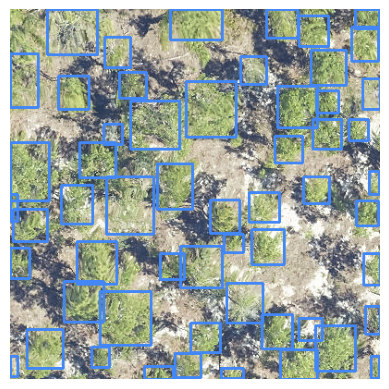

In [3]:
from deepforest import get_data
from deepforest.visualize import plot_results
from deepforest.utilities import read_file

boxes = m.predict_image(path=get_data("OSBS_029.png"))

print(boxes)
plot_results(boxes)

In [4]:
# Load the box dataset
from milliontrees import get_dataset
from milliontrees.common.data_loaders import get_eval_loader

box_dataset = get_dataset("TreeBoxes", download=False, version="0.4",root_dir="/orange/ewhite/web/public/MillionTrees")
box_test_data = box_dataset.get_subset("test")

The general workflow is to yield a image, and targets (orange), make a predictions (blue) and evaluate the metric. 

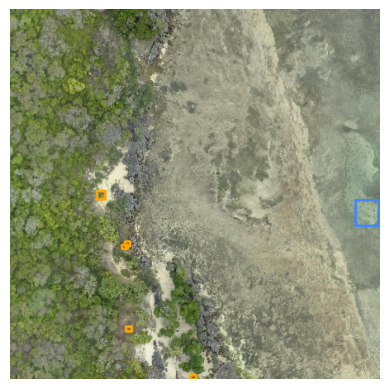

In [5]:
metadata, image, targets = box_test_data[250]
image_path = box_dataset._filename_id_to_code[int(metadata[0])]
image_path = os.path.join(box_dataset._data_dir._str, "images", image_path)

# Load the image, in this case DeepForest expects a numpy array, channels first, 0-255.
channels_first = image.permute(1, 2, 0).numpy() * 255
boxes = m.predict_image(channels_first)
ground_truth = read_file(
    pd.DataFrame(targets["y"].numpy(), columns=["xmin", "ymin", "xmax",
                                                "ymax"]))
ground_truth["label"] = "Tree"
plot_results(boxes, ground_truth, image=channels_first.astype("int32"))

## Evaluation example

Every model will output predictions in a slightly different way. MillionTrees expects a dictionary of tensors, same format between predictions and ground truth.

In [6]:
y_pred = {}
y_pred["y"] = torch.tensor(boxes[["xmin", "ymin", "xmax",
                                  "ymax"]].values.astype("float32"))
y_pred["labels"] = torch.tensor(
    boxes.label.apply(lambda x: m.label_dict[x]).values.astype(np.int64))
y_pred["scores"] = torch.tensor(boxes.score.values.astype("float32"))

# The eval method takes in batches, so wrap this one example in a liste
# To recover just one metric, you can grab the object directly.
box_test_data.eval([y_pred], [targets],
                   metadata=torch.unsqueeze(metadata, dim=0))

({'accuracy': {'detection_accuracy_avg': 0.0,
   'detection_accuracy_source_id:0': 0.0,
   'count_source_id:0': 1.0,
   'detection_accuracy_wg': 0.0},
  'recall': {'detection_recall_avg': 0.0,
   'detection_recall_source_id:0': 0.0,
   'count_source_id:0': 1.0,
   'detection_recall_wg': 0.0},
  'detection_acc_avg_dom': np.float64(nan)},
 '\n============================================================\nACCURACY RESULTS\n============================================================\n\nSummary Statistics:\n----------------------------------------\nAverage accuracy: 0.000\nWorst-group accuracy: 0.000\n\n============================================================\nRECALL RESULTS\n============================================================\n\nSummary Statistics:\n----------------------------------------\nAverage recall: 0.000\nWorst-group recall: 0.000\nAverage detection_acc across source: nan\nAverage detection_accuracy: 0.000\n  source_id = 0  [n =      1]:\tdetection_accuracy = 0.000\nWo

The evaluation dictionary is broken down by 'sources' which are individual projects contributed to the MillionTrees project, listed on the 'datasets' page on the docs. For each source the dictionary gives a count of the number of images, and then the bounding box mAP accuracy score. Then it gives the average within-group 'wg' score, and the average over all groups. In this example, we just have 1 image from 1 source, so the rest of groups are nan. Let's look at the entire dataset.

For most evaluation workflows there will be some intermediary code to format the output of whatever prediction workflow to the desired eval format. It would also be nice to have a plotting function to see some examples.

In [10]:
import warnings
from deepforest.utilities import format_geometry

def format_deepforest_prediction(images, metadata, targets, m, batch_index):
    # Suppress user warnings to make more readable
    warnings.filterwarnings("ignore")

    images = torch.tensor(images)
    predictions = m.predict_step(images, batch_index)
    batch_results = []
    formatted_predictions = []
    for image_metadata, pred, image_targets, image in zip(
            metadata, predictions, targets, images):
        basename = box_dataset._filename_id_to_code[int(image_metadata[0])]
        if len(pred["boxes"]) == 0:
            y_pred = {}
            y_pred["y"] = torch.zeros(4)
            y_pred["labels"] = torch.zeros(1)
            y_pred["scores"] = torch.zeros(1)
        else:
            formatted_pred = format_geometry(pred)
            formatted_pred.root_dir = os.path.join(box_dataset._data_dir._str, "images")
            formatted_pred["image_path"] = basename
            # Reformat to milliontrees format
            y_pred = {}
            y_pred["y"] = torch.tensor(formatted_pred[["xmin", "ymin", "xmax",
                                             "ymax"]].values.astype("float32"))
            y_pred["labels"] = torch.tensor(formatted_pred.label)
            y_pred["scores"] = torch.tensor(formatted_pred.score.values.astype("float32"))
        batch_results.append(y_pred)
        formatted_predictions.append(formatted_pred)

    return batch_results, formatted_predictions


# Helper function to plot evaluation results


def plot_eval_results(y_pred, pred, image_targets, image, batch_index):
    basename = pred.image_path.unique()[0]
    ground_truth = read_file(
        pd.DataFrame(image_targets["y"].numpy(),
                     columns=["xmin", "ymin", "xmax", "ymax"]))
    ground_truth["label"] = "Tree"
    predictions_df = read_file(pred)
    predictions_df["label"] = "Tree"
    # Make image channel last
    image = image.permute(1, 2, 0).numpy() * 255
    accuracy = box_dataset.metrics["recall"]._recall(image_targets["y"],
                                                     y_pred["y"],
                                                     iou_threshold=0.3)
    plot_results(predictions_df, ground_truth, image=image.astype("int32"))
    print(
        f"Image: {basename}, index {batch_index} with Detection Recall: {accuracy.item():.2f}"
    )

There are 67 batches in the test loader


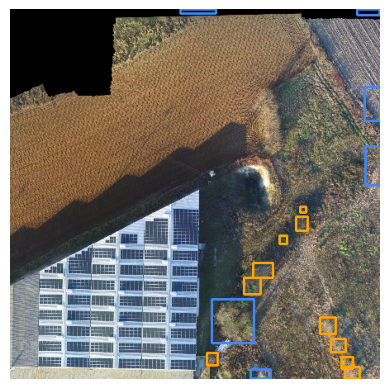

Image: test_3573.png, index 0 with Detection Recall: 0.00


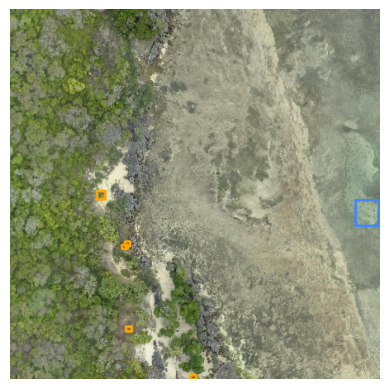

Image: train_2582.png, index 250 with Detection Recall: 0.00


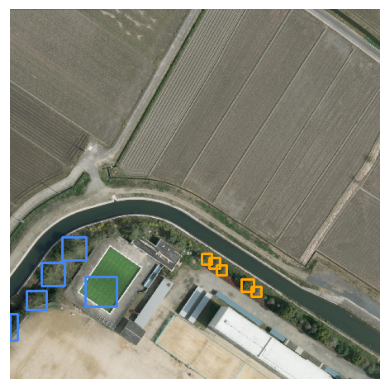

Image: train_1977.png, index 500 with Detection Recall: 0.00


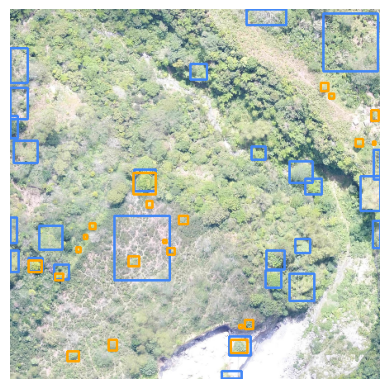

Image: train_1900.png, index 750 with Detection Recall: 0.14


IndexError: The shape of the mask [1] at index 0 does not match the shape of the indexed tensor [4] at index 0

In [13]:
# Get the test loader
test_loader = get_eval_loader("standard", box_test_data, batch_size=12)

# Print the length of the test loader
print("There are {} batches in the test loader".format(len(test_loader)))

# Get predictions for the full test set
all_y_pred = []
all_y_true = []

batch_index = 0
for batch in test_loader:
    metadata, images, targets = batch
    # Get the original DeepForest, and MillionTrees formatted predictions, this is just for plotting, otherwise you just need y_pred.
    milliontrees_format, deepforest_format = format_deepforest_prediction(images, metadata, targets, m, batch_index)
    for image_metadata, y_pred, pred, image_targets, image in zip(
            metadata, milliontrees_format, deepforest_format, targets, images):
        # Plot every 250th image
        if batch_index % 250 == 0:
            plot_eval_results(y_pred, pred, image_targets, image, batch_index)
        # Gather all predictions and ground truth
        all_y_pred.append(y_pred)
        all_y_true.append(image_targets)
        batch_index += 1

# Evaluate
box_dataset.eval(all_y_pred, all_y_true, box_test_data.metadata_array)